### Load Images

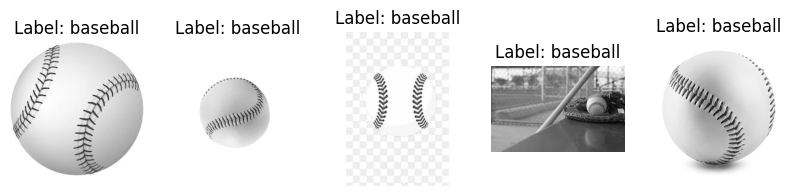

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
import os
from typing import List, Tuple, Optional


# Function to load images and labels from a directory
def load_images(folder: str, n: Optional[int] = None) -> Tuple[List[np.ndarray], List[str]]:
    images = []
    labels = []
    for label_folder in os.listdir(folder):
        count = 0
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            for img_file in glob(os.path.join(label_path, "*.jpg")):
                if n is not None and count >= n:
                    continue
                img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
                images.append(img)
                labels.append(label_folder)
                count += 1

    assert len(images) == len(labels), "Mismatch in number of images and labels"

    return images, labels

# Load images and labels from train and test folders
train_images, train_labels = load_images("data/train")
# test_images, test_labels = load_images("data/test")

# display some sample images with their labels
num_samples = 5
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

### Circle Detection

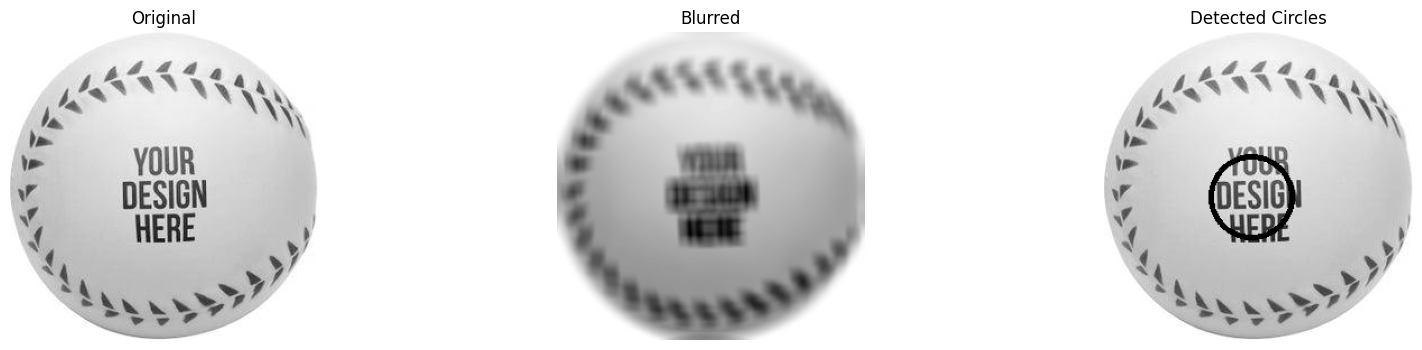

array([[131, 147,  36]])

In [31]:
import cv2


def detect_circles(image: np.ndarray, blur: int = 45, show: bool = False) -> np.ndarray:
    circles = [[]]
    while True:
        blurred_image = cv2.blur(image, (blur, blur))
        circles = cv2.HoughCircles(
            blurred_image,
            cv2.HOUGH_GRADIENT,
            dp=1.2,
            minDist=20,
            param1=60,
            param2=60,
            minRadius=10,
            maxRadius=1000
        )
        if circles is not None or blur < 3:
            break
        else:
            blur -= 2
    

    if show:
        circle_image = image.copy()
        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            for (x, y, r) in circles:
                cv2.circle(circle_image, (x, y), r, (0, 255, 0), 4)

        image_list = {
            "Original": image,
            "Blurred": blurred_image,
            "Detected Circles": circle_image
        }

        plt.figure(figsize=(20, 4))
        for i, (name, img) in enumerate(image_list.items()):
            plt.subplot(1, 3, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(name)
            plt.axis('off')

        plt.show()

    return circles


detect_circles(train_images[15], show=True)


### Crop to ball

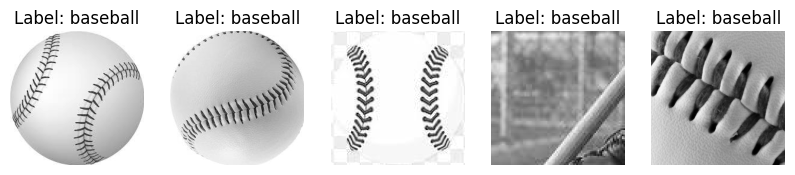

In [32]:
def crop_to_circle(img: np.ndarray, circles: np.ndarray) -> np.ndarray:
    if circles is not None:
        x, y, r = np.round(circles[0][0]).astype("int")
        cropped_img = img[y-r:y+r, x-r:x+r]
    else:
        cropped_img = img
    return cropped_img


cropped_images = []
for img in train_images:
    circles = detect_circles(img)
    cropped_images.append(crop_to_circle(img, circles))


# Display some cropped images
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(cropped_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

### Downsample images to the same size

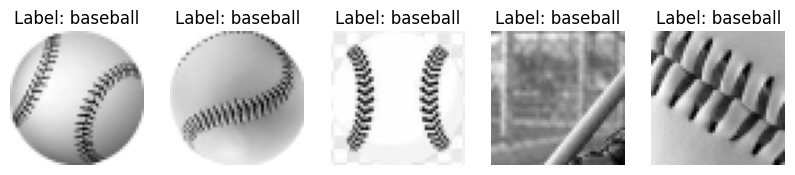

In [36]:
def downsample_images(images: List[np.ndarray]) -> List[np.ndarray]:
    downsampled_images = []
    min_height = min(img.shape[0] for img in images if img is not None and img.shape[0] > 0)
    min_width = min(img.shape[1] for img in images if img is not None and img.shape[1] > 0)
    shape = (min_width, min_height)
    for img in images:
        if img is None or img.shape[0] == 0 or img.shape[1] == 0:
            downsampled_images.append(None)
        else:
            downsampled_images.append(cv2.resize(img, shape, interpolation=cv2.INTER_AREA))
    return downsampled_images, shape


def remove_nones(images: List[np.ndarray], labels: List[str]) -> Tuple[List[np.ndarray], List[str]]:
    new_images = []
    new_labels = []
    for img, label in zip(images, labels):
        if img is not None and img.shape[0] > 48 and img.shape[1] > 48:
            new_images.append(img)
            new_labels.append(label)
    return new_images, new_labels


# Resize all images
processed_images, final_labels = remove_nones(cropped_images, train_labels)
final_images, shape = downsample_images(processed_images)

# Display some resized images
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(final_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

### Check number of circles found

In [ ]:
zero_count = 0
one_count = 0
multiple_count = 0

for img in final_images:
    if img is None:
        zero_count += 1
    elif len(img[0]) == 1:
        one_count += 1
    else:
        multiple_count += 1
        # print(len(all_circles[-1][0]))

print(f"Zero circles detected in {zero_count} images")
print(f"One circle detected in {one_count} images")
print(f"Multiple circles detected in {multiple_count} images")
    


Zero circles detected in 15 images
One circle detected in 801 images
Multiple circles detected in 384 images


### CNN

In [38]:
import keras
import keras.models
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


def train_model(input_x: np.ndarray, input_y: np.ndarray, shape: Tuple[int, int], epochs: int) -> Tuple[keras.Sequential, keras.callbacks.History]:
    input_x = np.array(input_x)
    # input_x = input_x.reshape((input_x.shape[0], shape[0], shape[1], 1))
    
    # Convert string labels to numerical values
    label_encoder = LabelEncoder()
    input_y = label_encoder.fit_transform(input_y)
    input_y = to_categorical(input_y)
    num_classes = input_y.shape[1]
    
    model = keras.Sequential()

    # convolutional layer 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(shape[0], shape[1], 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # convolutional layer 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # convolutional layer 3
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # dropout layer
    model.add(Dropout(0.5))

    # flatten the output
    model.add(Flatten())

    # fully connected layer
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # output layer
    model.add(Dense(num_classes, activation='softmax'))

    # compile the model and print summary
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    model.summary()

    # train the model
    history = model.fit(input_x, input_y, batch_size=128, epochs=epochs, validation_split=0.2)
    model.save("ball_cnn.keras")
    return model, history

epochs = 10
model, history = train_model(final_images, final_labels, shape, epochs)

c:\Users\jamie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 50, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,277,580 (4.87 MB)

 Trainable params: 1,276,620 (4.87 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.1494 - loss: 3.4099 - val_accuracy: 0.0000e+00 - val_loss: 25.1479
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.2779 - loss: 2.5234 - val_accuracy: 0.0000e+00 - val_loss: 14.0034
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.3300 - loss: 2.2307 - val_accuracy: 0.0000e+00 - val_loss: 7.4034
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.3688 - loss: 1.9753 - val_accuracy: 0.0000e+00 - val_loss: 7.9271
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.4513 - loss: 1.7488 - val_accuracy: 0.0000e+00 - val_loss: 5.9692
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5218 - loss: 1.5052 - val_accuracy: 0.0000e+00 - val_loss: 5.2038
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5371 - loss: 1.4231 - val_accuracy: 0.0000e+00 - val_loss: 3.8925
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5915 - loss: 1.2328 - va